## Figure 2. Unraveling the structural features of stems and their functional impact.
- 2A. Stem length distribution.
- 2B. In vitro processing results of pri-miRNAs binned by the stem length.
- 2C. Distributions of the upper and lower stem lengths.
- 2D. In vitro processing results of pri-miRNAs binned by the lower and upper stem lengths.
- 2E. Distribution of the number of mismatched pairs in the stem.
- 2F. In vitro processing results of pri-miRNAs binned by the number of mismatched pairs.
- 2G. Mismatch frequency in the stem.
- S2B-C. In vitro processing results of pri-miRNAs with and without a mismatch at -6 or +1.
- S2D. Distribution of the number of bulged or asymmetric bases in the stem.
- S2E. In vitro processing results of pri-miRNAs binned by the number of bulged/asym. bases.

In [3]:
import time
today = time.strftime('%Y-%m-%d')
name = 'S. Chan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by S. Chan Baek at 2024-01-25.


In [4]:
import os
HOME = '/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep'
SAVEPATH = '%s/%s/'%(HOME,time.strftime('%y%m%d'))
if not os.path.exists(SAVEPATH):
    os.makedirs(SAVEPATH)
print SAVEPATH
%cd $HOME

/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep/240125/
/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep


In [6]:
from __future__ import division
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from matplotlib import gridspec, lines, colors
from scipy.stats import pearsonr, mannwhitneyu, sem
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [7]:
s1 = pd.read_csv('publication/TableS1__Pri-miRNAs_selected_for_SHAPE-MaP.csv',index_col=0)
s2 = pd.read_csv('publication/TableS2__Constructs_used_in_this_study.csv',index_col=0)
s3 = pd.read_csv('publication/TableS3_2__SHAPE_reactivity.csv',index_col=0)
s3.columns = range(1,126)
s3cnts = pd.read_csv('publication/TableS3_1__Read_counts.csv',index_col=0)
s3shan = pd.read_csv('publication/TableS3_3__Shannon_entropy.csv',index_col=0)
s3shan.columns = range(1,126)
s3shan = s3shan.fillna(0)
s4str = pd.read_csv('publication/TableS4_1__SHAPE-based_pri-miRNA_structures.csv',index_col=0)
s4str.columns = range(1,126)
s4 = pd.read_csv('publication/TableS4_2__Structural_features_of_pri-miRNAs.csv',index_col=0)
constseqs = s2['Construct sequence'].to_dict()
folded = list(s4.index)
print len(folded)

476


In [10]:
releffs = s4['Cleavage efficiency (MP)']
relhoms = s4['Cleavage homogeneity (MP)']

In [11]:
def split_ct(ctfile):
    infos = open(ctfile, 'rt').read()
    length = int(infos.split('\n')[0].strip().split()[0])
    rna = infos.split('\n')[0].strip().split()[-1]
    nstrt = infos.count(rna)
    splitinfos = []
    for i in range(nstrt):
        lines = infos.split('\n')[1+(1+length)*i:(1+length)*(i+1)]
        splitinfos.append([ tuple(map(int,l.strip().split()[4:6][::-1])) for l in lines ])
    return splitinfos

In [31]:
def get_pre_position(mir):
    constseq = constseqs[mir].replace('T','U')
    preseq = s1.loc[mir, 'Precursor']
    return constseq.find(preseq)+1, constseq.find(preseq)+len(preseq)

### 2A. Stem length distribution.

In [13]:
roden = 'publication/Roden2017_TableS5.xls'
roden = pd.ExcelFile(roden).parse('Supplemental Table S5',header=25,index_col=1)
roden = roden[~roden.index.duplicated(keep='last')]
print len(roden)

1711


In [15]:
ms = [m for m in folded if m in roden.index]
print len(ms)

bins = [(20,30),(31,31),(32,32),(33,33),(34,34),(35,35),(36,36),(37,37),(38,38),(39,39),(40,50)]
xs = np.arange(30,41)
ys1 = [len([m for m in ms if lb<=s4.loc[m,'Stem length (bp)']<=ub]) for lb,ub in bins]
ys1 = np.array(ys1)/sum(ys1)*100
ys2 = [len([m for m in ms if lb<=roden.loc[m,'StemLength']<=ub]) for lb,ub in bins]
ys2 = np.array(ys2)/sum(ys2)*100
print len([m for m in folded if 34<=s4.loc[m,'Stem length (bp)']<=36])/len(folded)

414
0.567226890756


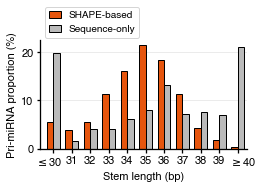

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3.7,2))
ax.bar(xs-.175,ys1,color='#e6550d',width=.35,edgecolor='k',lw=1,zorder=2,
      label='SHAPE-based')
ax.bar(xs+.175,ys2,color='#bababa',width=.35,edgecolor='k',lw=1,zorder=2,
      label='Sequence-only')
ax.set_xlabel('Stem length (bp)')
ax.set_ylabel('Pri-miRNA proportion (%)')
ax.set_xticks(xs)
ax.set_xticklabels(['$\leq$30    ']+list(xs[1:-1])+['   $\geq$40'])
ax.set_xlim(min(xs)-.7,max(xs)+.5)
ax.yaxis.grid(ls='-',lw=.5)
ax.legend(loc=(.02,1.02),handlelength=1.2)
#fig.savefig(resultpath+'230717_f2a__stem.pdf')

### 2B. In vitro processing results of pri-miRNAs binned by the stem length.

In [17]:
bins = [(20,33),(34,34),(35,35),(36,36),(37,50)]
msl = [[m for m in folded if lb<=s4.loc[m,'Stem length (bp)']<=ub] for lb,ub in bins]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs = np.arange(33,38)
ys1 = map(np.average,pes)
es1 = map(sem,pes)
ys2 = map(np.average,phs)
es2 = map(sem,phs)
labels = ['$\leq$33',34,35,36,'$\geq$37']
labels = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels,pes)]

In [19]:
print mannwhitneyu(pes[0],pes[1]+pes[2]+pes[3])[1]*2
print mannwhitneyu(pes[4],pes[1]+pes[2]+pes[3])[1]*2
print mannwhitneyu(phs[0],phs[1]+phs[2]+phs[3])[1]*2
print mannwhitneyu(phs[4],phs[1]+phs[2]+phs[3])[1]*2

0.0015373116592667046
0.01769629100392906
1.922517669916881e-05
0.00022080278998514276


Text(0,0.5,u'Cleavage homogeneity')

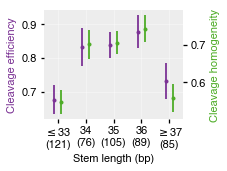

In [20]:
fig,ax = plt.subplots(1,1,figsize=(2.5,2))

ax.errorbar(xs-.12,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
axt = ax.twinx()
axt.errorbar(xs+.12,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
ax.set_xlim(min(xs)-.5,max(xs)+.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.grid(ls='-',lw=.7,color='w')
for a in [ax,axt]:
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
axt.tick_params(left='off',right='on')
ax.set_facecolor('#ededed')
ax.set_xlabel('Stem length (bp)')
ax.set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
#fig.savefig(resultpath + '230710_s2d__stem_processing.pdf')

### S2B. In vitro processing results of pri-miRNAs binned by the stem length (seq-only)

In [21]:
ms = [m for m in roden.index if m in releffs.keys()]
bins = [(20,33),(34,34),(35,35),(36,36),(37,50)]
msl = [[m for m in ms if lb<=roden.loc[m,'StemLength']<=ub] for lb,ub in bins]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs = np.arange(33,38)
ys1 = map(np.average,pes)
es1 = map(sem,pes)
ys2 = map(np.average,phs)
es2 = map(sem,phs)
labels = ['$\leq$33',34,35,36,'$\geq$37']
labels = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels,pes)]

Text(0,0.5,u'Cleavage homogeneity')

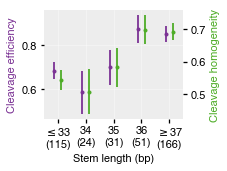

In [22]:
fig,ax = plt.subplots(1,1,figsize=(2.5,2))

ax.errorbar(xs-.12,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
axt = ax.twinx()
axt.errorbar(xs+.12,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
ax.set_xlim(min(xs)-.5,max(xs)+.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.grid(ls='-',lw=.7,color='w')
#ax.tick_params(labelsize=9.4,left='on')
for a in [ax,axt]:
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
axt.tick_params(left='off',right='on')
ax.set_facecolor('#ededed')
ax.set_xlabel('Stem length (bp)')
ax.set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
#fig.savefig(resultpath + '230710_s2d__stem_processing_roden.pdf')

### 2C. Distributions of the upper and lower stem lengths.

In [24]:
from matplotlib.colors import LinearSegmentedColormap, ColorConverter
to_rgb = ColorConverter().to_rgb
def custom_cmap(colors, cmap_name="newmap", nspace=3, linear=True):
    if (type(colors) is str) or (len(colors) is 1):
        colors = [colors, "white"]
    ncolors = len(colors)
    sidx = map(int, map(np.around, np.linspace(0, nspace-1, num=ncolors)))
    intervals = np.linspace(0, 1.0, num=nspace)
    rgb = ["red", "green", "blue"]
    cdict = {e:None for e in rgb}
    for element, components in zip(rgb, zip(*[to_rgb(c) for c in colors])):
        intensities = [components[0]]
        for i, value in enumerate(components):
            if i + 1 == len(components): break
            v1, v2 = components[i:i+2]
            intensities += list(np.linspace(v1, v2, num=sidx[i+1] - sidx[i] + 1))[1:]
        cdict[element] =  zip(intervals, intensities, intensities)
    return LinearSegmentedColormap(cmap_name, cdict)

In [25]:
lmin,lmax = 10, 16
umin,umax = 19, 25
lstems, ustems = {}, {}
data = pd.DataFrame(index=range(lmin,lmax+1),columns=range(umin,umax+1)).fillna(0)
for m in folded:
    ls,us = s4.loc[m,['Lower stem length (bp)','Upper stem length (bp)']]
    ls = min(max(lmin,ls),lmax)
    us = min(max(umin,us),umax)
    data.loc[ls,us] += 1
print data.sum().sum()
c = '#424242'
red = custom_cmap(['#f0f0f0','#de2d26'])
xsl = range(lmin,lmax+1); ysl = data.T.sum()/len(folded)*100
xsu = range(umin,umax+1); ysu = data.sum()/len(folded)*100

476


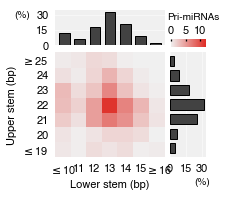

In [26]:
fig = plt.figure(figsize=(2.7,2.7))
gs = gridspec.GridSpec(2, 2, width_ratios=(3,1), height_ratios=(1,3))
ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[2]); ax3 = fig.add_subplot(gs[3])
fig.subplots_adjust(wspace=.07, hspace=.107)

ax1.bar(xsl,ysl,color=c,zorder=2,width=.7,lw=1,edgecolor='k')
ax3.barh(xsu,ysu,color=c,zorder=2,height=.7,lw=1,edgecolor='k')
im = ax2.pcolor(data.T/len(folded)*100,cmap=red,vmin=0,vmax=12)

axcb = fig.add_axes([0.72, 0.69, 0.18, 0.04])
cb = plt.colorbar(im, cax=axcb, orientation='horizontal')
axcb.xaxis.set_ticks_position('top')
cb.set_ticks([0,5,10]); cb.set_ticklabels([0,5,10])
axcb.tick_params(direction='in',length=2)
cb.outline.set_linewidth(0); cb.solids.set_rasterized(True)
axcb.text(.63,3.5,'Pri-miRNAs',ha='center')

ax2.set_xticks(np.arange(len(data))+.5); ax2.set_yticks(np.arange(len(data))+.5)
ax2.set_xticklabels(['$\leq$10 ',11,12,13,14,15,' $\geq$16'])
ax2.set_yticklabels(['$\leq$19',20,21,22,23,24,'$\geq$25'])
ax1.set_xticks([]); ax3.set_yticks([])

for ax in [ax1,ax3]:
    ax.set_facecolor('#f0f0f0')
    ax.tick_params(left='off',bottom='off')
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
ax1.yaxis.grid(ls='-',lw=1,color='w'); ax3.xaxis.grid(ls='-',lw=1,color='w')
ax1.set_yticks([0,15,30]); ax3.set_xticks([0,15,30])
ax1.set_xlim(lmin-.6,lmax+.6); ax3.set_ylim(umin-.6,umax+.6)
ax1.text(6.7,30,'(%)',va='center'); ax3.text(30,16.5,'(%)',ha='center')
    
ax2.set_xlabel('Lower stem (bp)')
ax2.set_ylabel('Upper stem (bp)')
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(left='off',bottom='off')
#fig.savefig(resultpath + '220527_f2c__lsus.pdf')

### 2D. In vitro processing results of pri-miRNAs binned by the lower and upper stem lengths.

In [27]:
bins = [(-5,11),(12,12),(13,13),(14,14),(15,30)]
msl = [[m for m in folded if lb<=s4.loc[m,'Lower stem length (bp)']<=ub] for lb,ub in bins]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs2 = np.arange(11,16)
ys21 = map(np.average,pes)
es21 = map(sem,pes)
ys22 = map(np.average,phs)
es22 = map(sem,phs)
labels2 = ['$\leq$11',12,13,14,'$\geq$15']
labels2 = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels2,pes)]
for x,pe,ph in zip([11,12,14,15],pes[:2]+pes[3:],phs[:2]+phs[3:]):
    print '%s %.5f %.5f'%(x,mannwhitneyu(pes[2],pe)[1]*2,mannwhitneyu(phs[2],ph)[1]*2)
    
bins = [(-5,20),(21,21),(22,22),(23,23),(24,40)]
msl = [[m for m in folded if lb<=s4.loc[m,'Upper stem length (bp)']<=ub] for lb,ub in bins]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs3 = np.arange(20,25)
ys31 = map(np.average,pes)
es31 = map(sem,pes)
ys32 = map(np.average,phs)
es32 = map(sem,phs)
labels3 = ['$\leq$20',21,22,23,'$\geq$24']
labels3 = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels3,pes)]
for x,pe,ph in zip([20,21,23,24],pes[:2]+pes[3:],phs[:2]+phs[3:]):
    print '%s %.4f %.4f'%(x,mannwhitneyu(pes[2],pe)[1]*2,mannwhitneyu(phs[2],ph)[1]*2)
    
xsl = [xs2,xs3]
ysl1 = [ys21,ys31]
ysl2 = [ys22,ys32]
esl1 = [es21,es31]
esl2 = [es22,es32]
labell = [labels2,labels3]
xlabels = ['Lower stem length (bp)','Upper stem length (bp)']

11 0.00007 0.00000
12 0.00898 0.00901
14 0.68854 0.03386
15 0.00061 0.00495
20 0.2762 0.3936
21 0.5545 0.9488
23 0.2277 0.2159
24 0.0672 0.1034


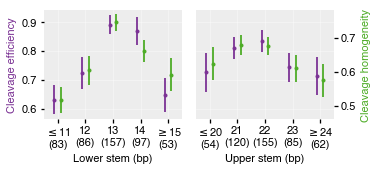

In [28]:
fig,axes = plt.subplots(1,2,figsize=(5.2,2),sharey=True)

for ax,xs,ys1,ys2,es1,es2,labels,xlab in zip(axes,xsl,ysl1,ysl2,esl1,esl2,labell,xlabels):
    ax.errorbar(xs-.12,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
    axt = ax.twinx()
    axt.errorbar(xs+.12,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
    ax.set_xlim(min(xs)-.5,max(xs)+.5)
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.grid(ls='-',lw=.7,color='w')
    ax.tick_params(left='off')
    axt.spines['left'].set_visible(False)
    axt.spines['bottom'].set_visible(False)
    ax.set_yticklabels([]); axt.set_yticklabels([])
    axt.tick_params(left='off',right='off')
    axt.set_ylim(.46,.78)

for ax in axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('#ededed')
    
axes[0].tick_params(left='on'); axt.tick_params(right='on')
axes[0].set_yticks([.6,.7,.8,.9]); axes[0].set_yticklabels([.6,.7,.8,.9])
axt.set_yticks([.5,.6,.7]); axt.set_yticklabels([.5,.6,.7])
axes[0].set_xlabel('Lower stem (bp)'); axes[1].set_xlabel('Upper stem (bp)')
axes[0].set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
fig.subplots_adjust(wspace=.1)
#fig.savefig(resultpath + '220527_f2d__lsus_processing.pdf')

### 2G. Mismatch frequency in the stem.

In [29]:
def get_sym_str(ctinfo, ps, pe):
    stinfo = [(x,y) for x,y in ctinfo if y>0]
    ls = [ (x,y) for i,(x,y) in enumerate(stinfo[:-1]) 
          if stinfo[i+1]==(y,x) and x>ps and y<pe ]
    loopst, loopen = min(ls, key=lambda (x,y):abs(120-x-y))
    stems = [ (i,p) for i,p in ctinfo if i<=loopst and loopen<=p ]
    if len(stems)<2:
        return 'F'*125
    stemst, stemen = stems[0]
    stems = stems + [ (p,i) for i,p in stems[::-1] ]
    symst = ''
    for (l5,l3),(u5,u3) in zip(stems[:-1],stems[1:]):
        if l5==loopst: symst += 'M'+'L'*(loopen-loopst-1)
        elif u5-l5==1: symst += 'M'
        else:
            symmet = min(u5-l5-1, l3-u3-1)
            symst += 'M' + symmet*'S' + (u5-l5-1-symmet)*'A'# + symmet*'S'
    symst = 'F'*(stemst-1) + symst + 'M' + 'F'*(125-stemen)
    return symst

In [39]:
mmtbl = pd.DataFrame(index=folded,columns=range(-15,25))
for m in folded:
    ctinfo = list(s4str.loc[m].items())
    ps, pe = get_pre_position(m)
    symstr = get_sym_str(ctinfo, ps, pe)
    ajs, aje = map(int,s4.loc[m,'Apical junction position'].split(', '))
    bjs, bje = map(int,s4.loc[m,'Basal junction position'].split(', ')) 
    usstr = symstr[ps-1:ajs].replace('A','')+symstr[ajs:ajs+2]
    lsstr = symstr[bjs-3:bjs-1]+symstr[bjs-1:ps-1].replace('A','')
    usstr = [0 if s=='M' else 1 for s in usstr]
    lsstr = [0 if s=='M' else 1 for s in lsstr]
    strd = dict(zip(range(25),usstr)); strd.update(dict(zip(range(-1,-16,-1),lsstr[::-1])))
    mmtbl.loc[m] = pd.Series(strd)
mmtbl.head(3)

,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,...,15,16,17,18,19,20,21,22,23,24
hsa-let-7a-1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,NaN,NaN
hsa-let-7a-2,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,1,NaN
hsa-let-7a-3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,NaN,NaN


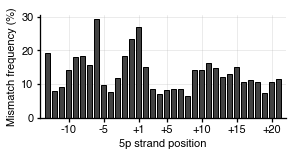

In [40]:
xs = range(-13,21)
ys = mmtbl[xs].sum()/len(folded)*100
xtks = range(-10,1,5)+range(4,20,5)
xtls = range(-10,0,5)+['+1','+5','+10','+15','+20']

fig, ax = plt.subplots(1, 1, figsize=(4.4,1.9))
ax.bar(xs,ys,color='#424242',zorder=2,width=.7,edgecolor='k',lw=1)

ax.set_xlim(min(xs)-1,max(xs)+1)
ax.set_xticks(xtks)
ax.set_xticklabels(xtls)
ax.set_xlabel('5p strand position')
ax.set_ylabel('Mismatch frequency (%)')
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '230705_f2e__mismatch.pdf')

In [41]:
major5p = s1[s1['Guide']=='5p'].reindex(folded).dropna().index
major3p = s1[s1['Guide']=='3p'].reindex(folded).dropna().index
print len(major5p), len(major3p)

270 206


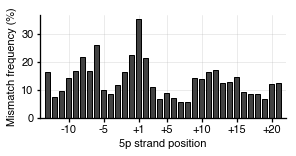

In [42]:
## 5p guide
xs = range(-13,21)
ys = mmtbl.reindex(major5p)[xs].sum()/len(major5p)*100
xtks = range(-10,1,5)+range(4,20,5)
xtls = range(-10,0,5)+['+1','+5','+10','+15','+20']

fig, ax = plt.subplots(1, 1, figsize=(4.4,1.9))
ax.bar(xs,ys,color='#424242',zorder=2,width=.7,edgecolor='k',lw=1)

ax.set_xlim(min(xs)-1,max(xs)+1)
ax.set_xticks(xtks)
ax.set_xticklabels(xtls)
ax.set_xlabel('5p strand position')
ax.set_ylabel('Mismatch frequency (%)')
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '230705_f2e__mismatch_5p.pdf')

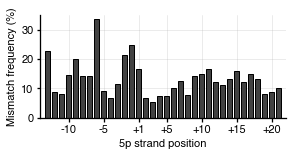

In [43]:
## 3p guide
xs = range(-13,21)
ys = mmtbl.reindex(major3p)[xs].sum()/len(major3p)*100
xtks = range(-10,1,5)+range(4,20,5)
xtls = range(-10,0,5)+['+1','+5','+10','+15','+20']

fig, ax = plt.subplots(1, 1, figsize=(4.4,1.9))
ax.bar(xs,ys,color='#424242',zorder=2,width=.7,edgecolor='k',lw=1)

ax.set_xlim(min(xs)-1,max(xs)+1)
ax.set_xticks(xtks)
ax.set_xticklabels(xtls)
ax.set_xlabel('5p strand position')
ax.set_ylabel('Mismatch frequency (%)')
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '230705_f2e__mismatch_3p.pdf')

### 2E. Distribution of the number of mismatched pairs in the stem.

In [44]:
bins = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,50)]
xs = range(0,9)
ys = [len([m for m in folded if lb<=s4.loc[m,'Mismatches']<=ub]) for lb,ub in bins]
ys = np.array(ys)/len(folded)*100
print ys

[ 1.68067227  7.77310924 15.54621849 18.69747899 19.74789916 14.70588235
 10.08403361  6.72268908  5.04201681]


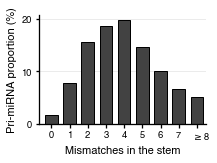

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.bar(xs,ys,color='#424242',width=.7,edgecolor='k',lw=1,zorder=2)

ax.set_xlabel('Mismatches in the stem')
ax.set_ylabel('Pri-miRNA proportion (%)')
ax.set_xticks(xs)
ax.set_xticklabels(xs[:-1]+['   $\geq$8'])
ax.set_yticks([0,10,20])
ax.set_xlim(min(xs)-.7,max(xs)+.5)
ax.yaxis.grid(ls='-',lw=.5)
ax.tick_params(labelsize=9.4)
#fig.savefig(resultpath+'220527_f2f__mismatch_count.pdf')

### 2F. In vitro processing results of pri-miRNAs binned by the number of mismatched pairs.

In [46]:
bins = [(0,1),(2,3),(4,5),(6,7),(8,30)]
msl = [[m for m in folded if lb<=s4.loc[m,'Mismatches']-s4.loc[m,'Mismatch at -6']<=ub] 
       for lb,ub in bins]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs = np.arange(len(bins))
ys1 = map(np.average,pes)
es1 = map(sem,pes)
ys2 = map(np.average,phs)
es2 = map(sem,phs)
labels = ['0-1','2-3','4-5','6-7','$\geq$8']
print mannwhitneyu(pes[0],pes[1]+pes[2]+pes[3]+pes[4])[1]*2
print mannwhitneyu(phs[0],phs[1]+phs[2]+phs[3]+phs[4])[1]*2
#labels = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels,pes)]

0.0044046444656003795
0.002235095311166664


Text(0,0.5,u'Cleavage homogeneity')

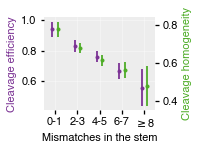

In [47]:
fig,ax = plt.subplots(1,1,figsize=(2,1.7))

ax.errorbar(xs-.12,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
axt = ax.twinx()
axt.errorbar(xs+.12,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
ax.set_xlim(min(xs)-.5,max(xs)+.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.grid(ls='-',lw=.7,color='w')
for a in [ax,axt]:
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
ax.tick_params(left='on')
axt.tick_params(left='off',right='on')
ax.set_facecolor('#ededed')
ax.set_xlabel('Mismatches in the stem')
ax.set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
#fig.savefig(resultpath + '220527_f2g__mismatch_processing.pdf')

### S2C-D. In vitro processing results of pri-miRNAs with and without a mismatch at -6 or +1.

In [48]:
msl = [mmtbl[mmtbl[-6]==1].index, mmtbl[mmtbl[-6]!=1].index]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs = np.arange(2)
ys1 = map(np.average,pes)
es1 = map(sem,pes)
ys2 = map(np.average,phs)
es2 = map(sem,phs)
labels = ['yes','no']
labels = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels,pes)]
print mannwhitneyu(pes[0],pes[1])[1]*2, mannwhitneyu(phs[0],phs[1])[1]*2

0.0030691576089133294 8.057223339719038e-05


Text(0,0.5,u'Cleavage homogeneity')

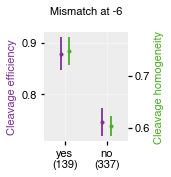

In [49]:
fig,ax = plt.subplots(1,1,figsize=(1.5,2))

ax.errorbar(xs-.1,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
axt = ax.twinx()
axt.errorbar(xs+.1,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
ax.set_xlim(min(xs)-.5,max(xs)+.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.grid(ls='-',lw=.7,color='w')
ax.tick_params(left='on')
ax.set_title('Mismatch at -6\n')
for a in [ax,axt]:
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
axt.tick_params(left='off',right='on')
ax.set_facecolor('#ededed')
#ax.set_yticks([.5,.6]); axt.set_yticks([.5,.6])
ax.set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
#fig.savefig(resultpath + '220530_s2_mismatch6.pdf')

In [50]:
msl = [mmtbl[mmtbl[0]==1].index, mmtbl[mmtbl[0]!=1].index]
pes = [[releffs[m] for m in ms] for ms in msl]
phs = [[relhoms[m] for m in ms] for ms in msl]
xs = np.arange(2)
ys1 = map(np.average,pes)
es1 = map(sem,pes)
ys2 = map(np.average,phs)
es2 = map(sem,phs)
labels = ['yes','no']
labels = ['%s\n(%s)'%(l,len(pe)) for l,pe in zip(labels,pes)]
print mannwhitneyu(pes[0],pes[1])[1]*2, mannwhitneyu(phs[0],phs[1])[1]*2

0.6047795061580055 0.1760031819084239


Text(0,0.5,u'Cleavage homogeneity')

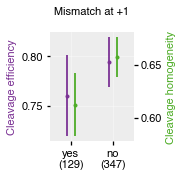

In [51]:
fig,ax = plt.subplots(1,1,figsize=(1.5,2))

ax.errorbar(xs-.1,ys1,yerr=es1,lw=0,elinewidth=1.8,ms=3,marker='o',color='#7b3294')
axt = ax.twinx()
axt.errorbar(xs+.1,ys2,yerr=es2,lw=0,elinewidth=1.8,ms=3,marker='o',color='#4dac26')
ax.set_xlim(min(xs)-.5,max(xs)+.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.grid(ls='-',lw=.7,color='w')
ax.tick_params(left='on')
ax.set_title('Mismatch at +1\n')
for a in [ax,axt]:
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
axt.tick_params(left='off',right='on')
ax.set_facecolor('#ededed')
ax.set_yticks([.75,.8])#; axt.set_yticks([.5,.6])
ax.set_ylabel('Cleavage efficiency',color='#7b3294')
axt.set_ylabel('Cleavage homogeneity',color='#4dac26')
#fig.savefig(resultpath + '220530_s2_mismatch1.pdf')